<a href="https://colab.research.google.com/github/renerubio/book-analysis/blob/main/editorial_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis y recomendación en el catálogo propio de libros

In [90]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Exploratoria inicial de los datos

Se carga el fichero que contiene los datos de todos los libros que conforman la lista

In [91]:
file_path = "https://github.com/renerubio/book-analysis/raw/refs/heads/main/all_books.csv"

df = pd.read_csv(file_path)

El catálogo de libros tienen un total de

In [92]:
original_shape = df.shape

original_shape

(1812, 21)

volúmenes y 22 propiedades. Los nombres y la relación de valores faltantes se muestra a continuación:

In [93]:
def compute_nas(df):
  nas = pd.DataFrame({ 'Cantidad': df.isna().sum()})
  nas['Porciento'] = nas['Cantidad'] / df.shape[0]

  return nas

compute_nas(df)

,Cantidad,Porciento
book_id_title,0,0.000000
book_id,0,0.000000
cover_image_uri,0,0.000000
book_title,0,0.000000
book_series,1308,0.721854
book_settings,767,0.423289
book_characters,727,0.401214
book_language,164,0.090508
year_first_published,5,0.002759
authorlink,0,0.000000


Nótese la presencia de columnas con proporciones elevadas de valores faltantes. Para algunas, como los personajes del libro, sí son indicativos de ausencia de información. Sin embargo, en casos como la serie a la que pertenece el libro, el valor faltante puede significar que este es una publicación individual, no vinculado a una saga.

### Integridad de los datos

Se realizan comprobaciones sobre algunas de las características para validar la integridad de la información.

Primeramente, busca determinarse la existencia de libros duplicados, ya que fueron identificadas algunas listas, principalmente abiertas, en las que el mismo libro estaba presente en más de una ocasión. La comparación se realiza a nivel del título del libro, dado que una misma obra puede poseer diferentes identificadores en dependencia de la edición, país de realización de esta, y otros factores.

In [94]:
counts = df['book_title'].value_counts()
counts = counts[counts > 1]

counts

,count
book_title,
Fractured,2
Inferno,2


Lo que identifica la existencia de dos títulos de libros repetidos. Al comprobar estos registros se observa que en realidad se trata de obras diferentes que comparten título

In [95]:
df[df['book_title'].isin(counts.index.to_list())]

,book_id_title,book_id,cover_image_uri,book_title,book_series,book_settings,book_characters,book_language,year_first_published,authorlink,...,num_pages,format,genres,people_curr_read,peop_want_to_read,num_ratings,num_reviews,average_rating,rating_distribution,awards
293,15645.Inferno,15645,https://images-na.ssl-images-amazon.com/images...,Inferno,['La Divina Commedia'],NaN,"['Virgilio (Publius Vergilius Maro)', 'Odysseu...",English,1320.0,https://www.goodreads.com/author/show/5031312....,...,490.0,Kindle Edition,"['Classics', 'Poetry', 'Fiction', 'Literature'...",15.7k,273k,194502,8859,4.03,"{'5 Stars': 75211, '4 Stars': 66841, '3 Stars'...",['Los Angeles Times Book Prize for Poetry (199...
354,17212231-inferno,17212231,https://images-na.ssl-images-amazon.com/images...,Inferno,['Robert Langdon'],"['Istanbul', 'Florence, Tuscany', 'Venice']","['Robert Langdon', 'Sienna Brooks', 'Laurence ...",English,2013.0,https://www.goodreads.com/author/show/630.Dan_...,...,463.0,Hardcover,"['Fiction', 'Thriller', 'Mystery', 'Mystery Th...",21.9k,248k,573181,39825,3.90,"{'5 Stars': 177715, '4 Stars': 214515, '3 Star...",['Goodreads Choice Award for Mystery & Thrille...
543,2199587.Fractured,2199587,https://images-na.ssl-images-amazon.com/images...,Fractured,['Will Trent'],"['Atlanta, Georgia']","['Angie Polaski', 'Will Trent', 'Faith Mitchel...",English,2008.0,https://www.goodreads.com/author/show/12504.Ka...,...,388.0,Hardcover,"['Mystery', 'Thriller', 'Crime', 'Fiction', 'A...","5,966",32.9k,88832,4035,4.16,"{'5 Stars': 32258, '4 Stars': 41495, '3 Stars'...",['Prix Polar International (2011)']
972,36593216-fractured,36593216,https://images-na.ssl-images-amazon.com/images...,Fractured,['Unbreakable'],NaN,NaN,English,2017.0,https://www.goodreads.com/author/show/17327390...,...,201.0,Kindle Edition,"['Paranormal', 'Paranormal Romance', 'Romance'...",2,519,55,40,4.40,"{'5 Stars': 36, '4 Stars': 10, '3 Stars': 6, '...",[]


## Preparación de features para modelización

A continuación se detallan las transformaciones aplicadas sobre los datos para obtener las features a emplear en los modelos, tanto recomendador como los empleados para describir los factores de éxito de los libros.

### Estandarización de géneros

El atributo `book_genre` contiene una lista indicando los géneros de un libro. Para cada instancia hay una lista de longitud variable en la que solo aparecen aquellos asociados al libro. Además, se han identificado algunas categorías arbitrarias, específicas a unas pocas instancias, e incluso relacionadas con otras temáticas, como nombres de premios recibidos.

Para obtener un formato utilizable en un modelo se decide generar un conjunto de géneros estándar, que agrupe aquellos con significado común y en última instancia descarte los casos anómalos descritos con anterioridad. El atributo será recodificado a un vector de longitud fija que marcará la asociación o no de un género de los definidos con el libro, lo cual permite el uso de métricas de distancia.

Primeramente, se obtienen todos los géneros diferentes presentes en el dataset y la columna original es transformada de formato texto a lista de python, para poder procesarse directamente a futuro:

In [96]:
import ast
import re

genres = {}

def get_genres_and_normalize(l, d):
  if not pd.isna(l):
    l = ast.literal_eval(l)
    news = []

    for g in l:
      k = re.sub(r'\s+', ' ', g.split('(')[0].strip().lower())

      if k in d.keys():
        d[k] += 1
      else:
        d[k] = 1

      news.append(k)
    return news
  else:
    return pd.NA

df['genres'] = df['genres'].apply(lambda r: get_genres_and_normalize(r, genres))

#### Estandarización mediante embeddings

Dado que los géneros son texto, y entre las categorías existentes hay múltiples que comparten significado con diferente terminología, no es posible utilizar técnicas básicas de comparación términos. Se decide emplear modelos de embeding para la comparación semántica de los géneros.

Debido a que algunas categorías son multipalabra, son utilizados transformers de oración. En este caso, el modelo preentrenado [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), destinado al embedding de oraciones y textos cortos. El motivo principal de elección es el balance entre calidad y costo computacional que presenta.

In [97]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

def embed_genres(grs):
  genre_list = [g for g in grs]
  return genre_list, model.encode(genre_list)

Se decide utilizar el algoritmo DBSCAN para la generalización de clústeres, partiendo de la base que géneros con significado similar generarán regiones densas que permitan asociarlos. La métrica empleada es la distancia del coseno, opción para capturar la relación entre aquellos términos que sean subconjuntos de otros.

In [98]:
from sklearn.cluster import DBSCAN

genre_list, genre_vectors = embed_genres(genres.keys())

clustering = DBSCAN(eps=0.5, min_samples=3, metric="cosine").fit(genre_vectors)

cluster_map = {}
for genre, cluster in zip(genre_list, clustering.labels_):
    if cluster == -1:
        cluster_map[genre] = [genre]
    else:
        cluster_map.setdefault(cluster, []).append(genre)

{ cls: len(grs) for cls, grs in cluster_map.items() }

{np.int64(0): 304,
 'self help': 1,
 'personal development': 1,
 'lovecraftian': 1,
 'siglo de oro': 1,
 'nobel prize': 1,
 'pulp': 1,
 'dark': 1,
 'chick lit': 1,
 'coming of age': 1,
 'retellings': 1,
 'westerns': 1,
 'unfinished': 1,
 'roman': 1,
 'presidents': 1,
 'cyberpunk': 1,
 'autistic spectrum disorder': 1,
 'arthurian': 1,
 'robots': 1,
 'us presidents': 1,
 'sword and planet': 1,
 'pirates': 1,
 'reference': 1,
 'collections': 1,
 'inspirational': 1,
 'abuse': 1,
 'counting': 1,
 'steampunk': 1,
 'hugo awards': 1,
 'trains': 1}

Sin embargo, puede observarse que los clústeres resultantes están fuertemente desbalanceados. En realidad sólo se conforma un grupo con la mayoría de géneros dados y el resto son detectados como outliers y colocados aparte. Al analizar el clúster mayoritario:

In [99]:
cluster_map[0]

['fantasy',
 'fiction',
 'young adult',
 'magic',
 'childrens',
 'audiobook',
 'adventure',
 'classics',
 'german literature',
 'school',
 'literature',
 'novels',
 '20th century',
 'poetry',
 'picture books',
 'nursery rhymes',
 'travel',
 'nonfiction',
 'philosophy',
 'china',
 'middle grade',
 'history',
 'biography',
 'scotland',
 'historical',
 'british literature',
 'tudor period',
 'africa',
 'magical realism',
 'nigeria',
 'african literature',
 'literary fiction',
 'historical fiction',
 'romance',
 'horror',
 'short stories',
 'science fiction',
 'dinosaurs',
 'humor',
 'spanish literature',
 'poland',
 'polish literature',
 'contemporary',
 'gothic',
 'mystery',
 'crime',
 'mystery thriller',
 'mythology',
 'medieval',
 'animals',
 'france',
 'american revolution',
 'american history',
 'war',
 'russia',
 'russian literature',
 'time travel',
 'politics',
 'business',
 'french literature',
 'thriller',
 'paranormal',
 'adult',
 'espionage',
 'japan',
 'true crime',
 'suspens

Se observa que agrupa a todas aquellas categorías más cercanas a lo que se define como género literario. Esto ocurre para distintas combinaciones de los parámetros de distancia máxima entre instancias (eps) y la densidad del clúster (min_samples).

Un enfoque alternativo es el uso de agrupamiento aglomerativo, dado que el conjunto de vectores generados parece contener una región de mucha mayor densidad que el resto. Además, al estar basado en jerarquías permitiría captar las relaciones existentes entre términos compuestos. En este caso, se fija el número de clústers final a la longitud aproximada que se considera para el vector de géneros estandarizados.

In [100]:
from sklearn.cluster import AgglomerativeClustering

genre_list, genre_vectors = embed_genres(genres.keys())

clustering = AgglomerativeClustering(n_clusters=20, metric='euclidean', linkage='ward')
cluster_labels = clustering.fit_predict(genre_vectors)

cluster_map = {}
for genre, cluster in zip(genre_list, cluster_labels):
    cluster_map.setdefault(cluster, []).append(genre)

{ cls: len(grs) for cls, grs in cluster_map.items() }

{np.int64(18): 17,
 np.int64(14): 10,
 np.int64(1): 15,
 np.int64(4): 11,
 np.int64(0): 47,
 np.int64(3): 28,
 np.int64(9): 15,
 np.int64(19): 9,
 np.int64(7): 16,
 np.int64(11): 18,
 np.int64(2): 31,
 np.int64(6): 33,
 np.int64(10): 13,
 np.int64(17): 10,
 np.int64(15): 14,
 np.int64(8): 12,
 np.int64(5): 12,
 np.int64(12): 10,
 np.int64(16): 5,
 np.int64(13): 7}

El resultado presenta una mejor distribución de los géneros, sin la existencia de un clúster predominante. Sin embargo, al observar el que contiene la mayoría de instancias

In [101]:
cluster_map[0]

['adventure',
 'travel',
 'self help',
 'horror',
 'humor',
 'siglo de oro',
 'nobel prize',
 'time travel',
 'plays',
 'tragedy',
 'dark',
 'drama',
 'journalism',
 'action',
 'coming of age',
 'comedy',
 'theatre',
 'race',
 'survival',
 'film',
 'epic',
 'unfinished',
 'media tie in',
 'apocalyptic',
 'christmas',
 'holiday',
 'post apocalyptic',
 'robots',
 'space opera',
 'noir',
 'police',
 'friendship',
 'halloween',
 'music',
 'reference',
 'collections',
 'inspirational',
 'sports',
 'astronomy',
 'abuse',
 'love',
 'space',
 'counting',
 'hugo awards',
 'death',
 'chess',
 'trains']

Puede notarse que se repite la existencia de más de una temática natural dentro del mismo clúster. Aunque existe mayor relación entre varios elementos en el grupo, no llega a ser consistente con una única categoría general.

#### Estandarización mediante IA Generativa

Debido a que los algoritmos anteriores generan clústeres no consistentes con el significado completo de los géneros usados en el dataset, se decide emplear un mapeo basado en IA generativa, en la que un LLM de razonamiento crea un conjunto de géneros de orden superior que relaciona a los presentes en los datos. Además, esto permite incluir un caso inicialmente omitido en el agrupamiento tradicional: la existencia de géneros compuestos que podrían pertenecer a más de uno de los estandarizados.

La instrucción es la siguiente (por legibilidad, se ha omitido la lista de géneros)

```
You're a consultant for an editorial that is cataloging its stock.
You find that many books have genres  that don't suit the definition and that many common genres are named in different ways.
After analyzing the books you identify all this supposed genres:

<lista de géneros>

To better organize them you decide to create top-level genres that summarize the existing ones.
In order to keep the classification simple, you decide to:
- treat all the different terminology for a same subject as the same genre (e.g, 'romance', 'romantic', 'love')
- discard non-related terminology (such as categorization by an award or the edition's format)
- group related subjects into the same genre (for instance books about a war in different countries could be categorized as "millitary")
- include subgenres in more than one top-level genre (for instance, "american civil war" could fall into "military" and "historic" at the same time)
- avoid unprecise assumptions about a genre (for instance "young adult" doesn't gives enougth information to categorize the subgenre as "fiction" or "nonfiction")

You are the expert, the final names of the top-level genres as well as the amount are at your choice.
The library needs good definition and simplicity, so try to generate no more than 20 top-level genres, but you can go a bit over that limit.

Use json syntax for your result, where each key is the name of the top-level genre and the value the set of genres that fall into it
```

El resultado se almacena y carga de la carpeta raíz de los datos del proyecto. Los géneros de alto nivel obtenidos son los siguientes

In [102]:
import requests
import json

json_url = "https://github.com/renerubio/book-analysis/raw/refs/heads/main/new_genres_mapping.json"

# Descargar el contenido del JSON
response = requests.get(json_url)
response.raise_for_status()  # Verifica errores HTTP

# Cargar el JSON desde la respuesta
global_genres = json.loads(response.text)  # Usa response.json() si el contenido es JSON puro
genres_mapping = {}

for top_genre, subgenres in global_genres.items():
  for g in subgenres:
    if g in genres_mapping.keys():
      genres_mapping[g].append(top_genre)
    else:
      genres_mapping[g] = [top_genre]

genres_index = {}
total = 0

for i, g in enumerate(global_genres.keys()):
  genres_index[g] = i
  total += 1

genres_index

{'Fantasy': 0,
 'Science Fiction': 1,
 'Horror': 2,
 'Thriller': 3,
 'Romance': 4,
 'Historical': 5,
 'Military & War': 6,
 'Nonfiction': 7,
 "Children's & Young Adult": 8,
 'Drama': 9,
 'Fictionary': 10,
 'Short Stories': 11,
 'Literary & Classics': 12,
 'Poetry': 13,
 'Religious & Spiritual': 14,
 'Regional & National': 15,
 'Science & Technology': 16,
 'Arts, Culture & Design': 17,
 'Social': 18,
 'Self-Help': 19,
 'Humor & Comedy': 20,
 'Western': 21,
 'Nature & Animals': 22,
 'Adventure': 23}

 A partir de estos se genera un vector binario que indica cuándo un libro pertence o no a cada género de alto nivel. En el caso de libros en los que la información del género era un valor faltante, el resultado será un vector de ceros

In [103]:
def assign_genres(subgenres):
  corresponding_genres = set()
  vector = np.zeros(total)

  if isinstance(subgenres, list):
    for g in subgenres:
      if g in genres_mapping.keys():
        for main in genres_mapping[g]:
          i = genres_index[main]
          corresponding_genres.add(main)

          if vector[i] == 0:
            vector[i] = 1
  return list(corresponding_genres), vector

df[['main_genres', 'genres_vector']] = pd.DataFrame(df['genres'].apply(assign_genres).to_list())
df[['main_genres', 'genres_vector']]

,main_genres,genres_vector
0,"[Fantasy, Adventure, Children's & Young Adult]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,"[Fantasy, Adventure, Children's & Young Adult]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,"[Regional & National, Literary & Classics, Non...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,"[Fantasy, Poetry, Children's & Young Adult]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
4,"[Adventure, Nonfiction, Self-Help]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...
1807,"[Regional & National, Literary & Classics, Fic...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1808,"[Romance, Literary & Classics, Fictionary, Chi...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
1809,"[Regional & National, Literary & Classics, Fic...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1810,"[Regional & National, Romance, Historical, Lit...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."


### Distribución de variables numéricas y outliers

Se analizan las variables numéricas y algunos indicadores calculables a partir de otros atributos para validar las distribuciones y detectar posibles valores extremos o anómalos. La mayoría de estas utilizan el formato `10k` y `1.5m` para indicar cantidades de decenas de miles y millones, respectivametne. Además, aquellos que no llegan a tal magnitud utilizan el separador inglés de miles `,`. Los valores numéricos deben transformarse para permitir su utilización.

In [104]:
numeric_feats = ['year_first_published', 'num_pages', 'peop_want_to_read', 'people_curr_read', 'num_ratings', 'num_reviews', 'average_rating']

def convert_to_numeric(value):
    if isinstance(value, str):
        value = value.lower().replace(",", "").strip()
        if "k" in value:
            return float(value.replace("k", "")) * 1_000
        elif "m" in value:
            return float(value.replace("m", "")) * 1_000_000
    try:
        return int(value)
    except ValueError:
        return None

df[numeric_feats] = df[numeric_feats].map(convert_to_numeric).infer_objects()

Los histogramas sobre los valores reformateados muestran las distribuciones de las variables numéricas:

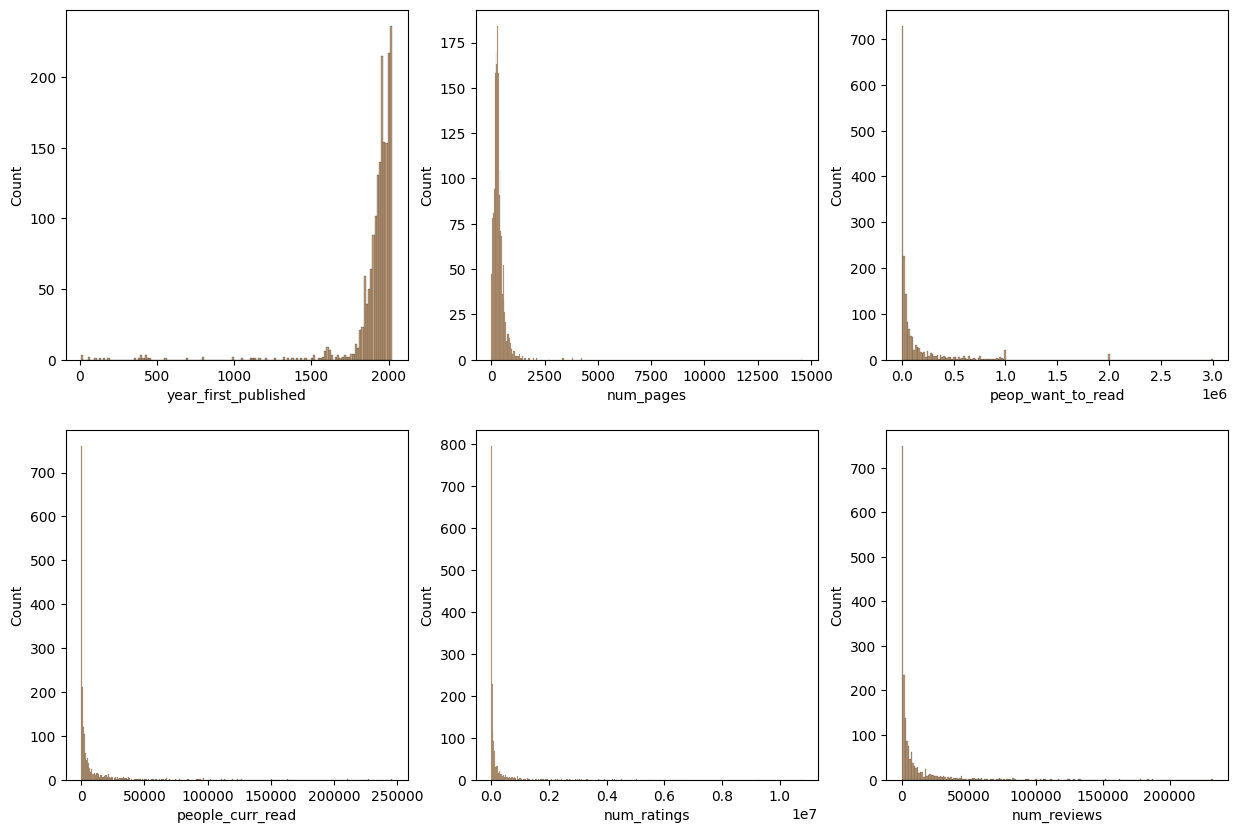

In [105]:

#colores de la presentación
custom_palette = ["#5D3A00", "#A87C4F", "#D9B38C", "#FFF1D0", "#C89F7E"]
rows = 2
cols = 3
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

for i in range(rows * cols):
    sns.histplot(df[numeric_feats].iloc[:, i], ax=axs[i],color=custom_palette[1])

Las cuales presentan notorios desbalanceos hacia los extremos. Dadas las características de los clásicos literarios, originarios de todas las épocas, es correcta la existencia de años tan alejados del rango principal de valores. Lo mismo ocurre con los intervalos de cantides de personas que desean o han leído los libros y los de cantidad de valoraciones y reseñas que han recibido. Son valores marcados por la popularidad o alcance de las obras, y es posible la presencia de libros con mucho mayor impacto que el resto de los datos.

Sin embargo, el extremo superior de la distribución de cantidad de páginas sí podría indicar anomalías en el dominio de los datos. Una vista más detallada de los rangos de la distribución

<Axes: ylabel='num_pages'>

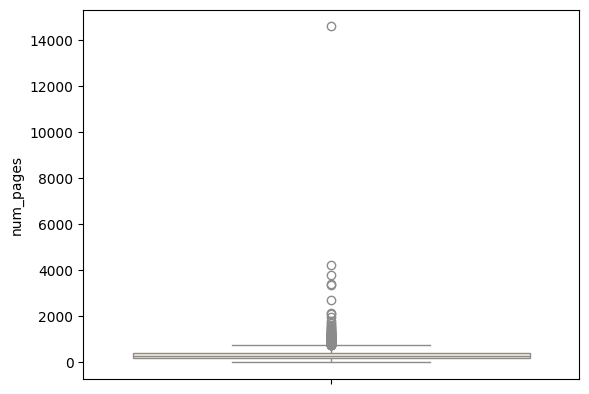

In [106]:
sns.boxplot(df['num_pages'], color=custom_palette[3])

Muestra la existencia de valores atípicos con respecto a la distancia intercuartílica y un punto extremo concreto, con un valor superior a 14 mil páginas.

Para una exploración inicial se escoge como punto de corte el que esté 1.5 veces más allá del tercer quantil más el rango interquantílico, el criterio común de outlier

In [107]:
q3 = df['num_pages'].quantile(q=0.75)
iqr = q3 - df['num_pages'].quantile(q=0.25)
threshold = q3 + iqr * 1.5

longs = df[df['num_pages'] > threshold].sort_values(by='num_pages', ascending=False)

longs.shape[0]

112

obras por encima de este umbral, por lo que se inspeccionan sólo los primeros y últimos elementos:

In [108]:
check_cols = ['book_title', 'book_series', 'author', 'num_pages']

pd.concat([longs.head(), longs.tail()])[check_cols]

,book_title,book_series,author,num_pages
443,Oeuvres completes: 101 titres La Comedie humaine,NaN,Honore de Balzac,14590.0
447,In Search of Lost Time,NaN,Marcel Proust,4211.0
893,Oakshot Complete Works of Oscar Wilde (Illustr...,NaN,Oscar Wilde,3799.0
833,The Complete Works of F. Scott Fitzgerald.,NaN,F. Scott Fitzgerald,3405.0
1,Harry Potter Collection,NaN,J.K. Rowling,3342.0
827,The Agony and the Ecstasy,NaN,Irving Stone,776.0
1106,Gravity's Rainbow,NaN,Thomas Pynchon,776.0
361,The Goldfinch,NaN,Donna Tartt,771.0
62,The Chronicles of Narnia,['The Chronicles of Narnia (Publication Order)...,C.S. Lewis,767.0
1384,Verso il paradiso,NaN,Hanya Yanagihara,767.0


Los registros con menor cantidad de páginas aún corresponden a libros más extensos, pero en cantidad aún normales. Sin embargo, de los títulos superiores puede intuirse que más allá de obras independientes, se trata de colecciones de autores o sagas resumidas en un solo registro.

La inspección ahora se realiza sobre más registros del grupo de mayor cantidad de páginas

In [109]:
longs.head(25)[check_cols]

,book_title,book_series,author,num_pages
443,Oeuvres completes: 101 titres La Comedie humaine,NaN,Honore de Balzac,14590.0
447,In Search of Lost Time,NaN,Marcel Proust,4211.0
893,Oakshot Complete Works of Oscar Wilde (Illustr...,NaN,Oscar Wilde,3799.0
833,The Complete Works of F. Scott Fitzgerald.,NaN,F. Scott Fitzgerald,3405.0
1,Harry Potter Collection,NaN,J.K. Rowling,3342.0
85,The Little House Collection,['Little House'],Laura Ingalls Wilder,2700.0
1395,The Leatherstocking Tales,['The Leatherstocking Tales'],James Fenimore Cooper,2126.0
944,The Complete Anne of Green Gables,['Anne of Green Gables'],L.M. Montgomery,2088.0
699,The Raj Quartet,['The Raj Quartet'],Paul Scott,1985.0
454,The Complete Sherlock Holmes,['Sherlock Holmes'],Arthur Conan Doyle,1796.0


Se observa que la mayoría de títilos indican recopilaciones, aunque existen algunos que sí corresponden a obras extensas, tanto individuales como aquellas de varios tomos, pero que conforman una única novela.

Debido al patrón identificado, se decide mantener el análisis sobre aquellas con los términos "collection" o "complete" en ellas, lo que genera

In [110]:
matchers = ['complete', 'collection']

no_individuals = df[df['book_title'].map(lambda title: any(term in title.lower() for term in matchers))]

no_individuals.shape[0]

25

registros. La distribución de estos demuestra que la mayoría se encuentra dentro del rango definido como posiblemente atípico:

<Axes: ylabel='num_pages'>

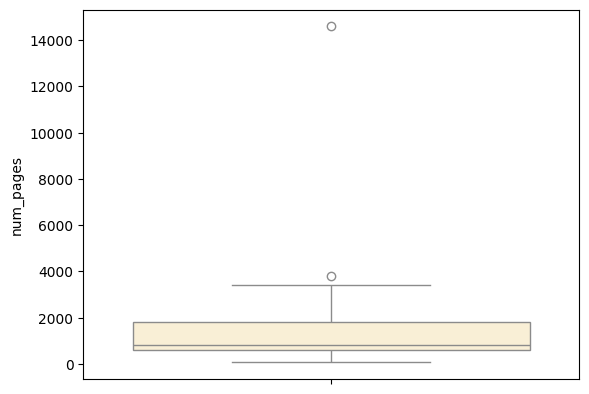

In [111]:
sns.boxplot(no_individuals['num_pages'],  color=custom_palette[3])

Sin embargo, algunos tienen números de páginas más cercanos a los libros individuales comunes, por lo que se analizan los ejemplares

In [112]:
no_individuals.head(25).sort_values(by='num_pages', ascending=False)[check_cols]

,book_title,book_series,author,num_pages
443,Oeuvres completes: 101 titres La Comedie humaine,NaN,Honore de Balzac,14590.0
893,Oakshot Complete Works of Oscar Wilde (Illustr...,NaN,Oscar Wilde,3799.0
833,The Complete Works of F. Scott Fitzgerald.,NaN,F. Scott Fitzgerald,3405.0
1,Harry Potter Collection,NaN,J.K. Rowling,3342.0
85,The Little House Collection,['Little House'],Laura Ingalls Wilder,2700.0
944,The Complete Anne of Green Gables,['Anne of Green Gables'],L.M. Montgomery,2088.0
454,The Complete Sherlock Holmes,['Sherlock Holmes'],Arthur Conan Doyle,1796.0
797,The Complete Essays,NaN,Michel de Montaigne,1344.0
1682,The Complete Oz,['Oz'],L. Frank Baum,1314.0
1353,The Complete Works,NaN,William Shakespeare,1229.0


Nótese que algunos de los libros identificados son recopilaciones no redundantes con otras obras individuales, como poemarios. Es probable que estos casos sean la única aparición de los autores en la lista, por lo que se comprueba el caso.

La tabla resumen muestra la cantidad de registros por autor, diferenciando las series a las que pertenece.

In [113]:
author_appearence = df.merge(no_individuals['author'], on='author').groupby('author')[['author', 'book_series']].value_counts(dropna=False)

author_appearence

author                   book_series                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
Agatha Christie          ['Hercule Poirot']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           4
                         NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          2
                         ['Hercule Poirot', 'Colonel Race']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           1
                         ['Miss Marple']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1
Arthur Conan Doyle       ['Sherlock Holmes']                                                                                                                                                                                                                                                                                                                                                                                                                  

Entre las seleccionadas efectivamente algunos recopilatorios son la única aparición del autor, estos casos serán conservados. También coinciden con libros que no eran precisamente una compilación de obras, pero por la terminología fueron filtradas.

In [114]:
various_appearances = author_appearence.groupby('author').sum().reset_index().query('count > 1')

various_appearances

,author,count
0,Agatha Christie,8
1,Arthur Conan Doyle,30
3,Beatrix Potter,6
5,Edgar Allan Poe,12
6,Edgar Rice Burroughs,38
7,Emily Dickinson,2
9,F. Scott Fitzgerald,6
10,Flannery O'Connor,2
11,Hans Christian Andersen,4
12,Honore de Balzac,6


Finalmente, se filtran los recopilatorios cuyos autores tienen más presencia en el listado del conjunto total de libros

In [115]:
exclude = no_individuals.merge(various_appearances, on='author', how='inner')
merging = df.merge(exclude, on='book_title', how='left', indicator=True).rename({ c + '_x': c for c in df.columns }, axis=1)

df = merging[merging['_merge'] == 'left_only'][df.columns].copy()
compilations = merging[merging['_merge'] == 'both'][df.columns].copy()

Al volver a comprobar la distribución de los valores:

<Axes: xlabel='num_pages', ylabel='Count'>

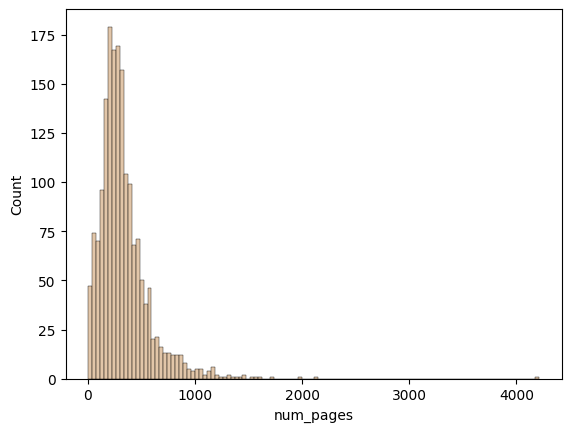

In [116]:
sns.histplot(df['num_pages'],  color=custom_palette[2])

Se observa que el rango de valores extremos se ha reducido considerablemente, aunque aún existen casos:

In [117]:
df[df['num_pages'] > 1500][check_cols]

,book_title,book_series,author,num_pages
447,In Search of Lost Time,NaN,Marcel Proust,4211.0
465,The Holy Bible: King James Version,NaN,Anonymous,1590.0
696,Les Rois maudits,['The Accursed Kings'],Maurice Druon,1620.0
699,The Raj Quartet,['The Raj Quartet'],Paul Scott,1985.0
771,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,['Middle Earth'],J.R.R. Tolkien,1728.0
1295,"Clarissa, or, The History of a Young Lady",NaN,Samuel Richardson,1534.0
1395,The Leatherstocking Tales,['The Leatherstocking Tales'],James Fenimore Cooper,2126.0


Puede identificarse un título que hace referencia a una colección de libros de J. R. R. Tolkien, que se descarta manualmente

In [118]:
df = df.drop(771).reset_index()

Aunque este registro no afecta la distribución general, se prefiere eliminar dado que no provee información consistente.

La nueva distribución, ya con valores correctos, será procesada junto al resto de variables numéricas

### Valoración contextual de los libros

El dataset cuenta con la valoración promedio dada a cada libro (campo `average_rating`). Sin embargo, la escala estándar del 1 al 5 no es del todo indicaiva de la calidad al no tener contexto sobre la puntuación que se le suele dar a los libros similares. Para obtener esta información se calcula el Z-Score de la valoración de un libro con respecto a sus similares. El criterio de similitud en este caso serán los géneros de orden superior en los que esté categorizado, de forma que se obtenga cuán alejado está un libro de la media de valoraciones que presenten.

In [119]:
genres_rating = {}

def get_ratings(dct, grs, rating):
  for g in grs:
    if g in dct.keys():
      dct[g].append(rating)
    else:
      dct[g] = [rating]

df.apply(lambda r: get_ratings(genres_rating, r['main_genres'], r['average_rating']), axis=1)

def compute_tendencies(grs, rating):
  if grs:
    all_related = []

    for g in grs:
      all_related += genres_rating[g]

    arr = np.array(all_related)

    return np.mean(arr), np.std(arr)
  else:
    return rating, 0

df[['contextual_mean', 'contextual_sd']] = pd.DataFrame(df.apply(lambda r: compute_tendencies(r['main_genres'], r['average_rating']), axis=1).to_list())
df['contextual_score'] = df.apply(lambda r: (r['average_rating'] - r['contextual_mean']) / r['contextual_sd'] if r['contextual_sd'] != 0 else 1, axis=1)

Además, se emplean estas medidas contextuales para realizar un mapeo del campo `rating_distribution`, que contiene una estructura anidada en forma de diccionario con la cantidad de valoraciones por cada punto de la escala de puntuación. El resultado final es un valor porcentual de cuántas valoraciones fueron de una puntuación por encima de la media de las obtenidas por el resto de libros con los que comparte género.

In [120]:
def above_standard_percent(mean, distribution):
  above = 0
  tot = 0

  for rating, amount in ast.literal_eval(distribution).items():
    if int(rating.split()[0]) > mean:
      above += amount

    tot += amount

  return above / tot

df['above_average'] = df.apply(lambda r: above_standard_percent(r['contextual_mean'], r['rating_distribution']), axis=1)

### Otros mapeos

Se realizan transformaciones sobre todos de los campos existentes, de forma que sean utilizables en los modelos o para la salida final.

- Conteo de premios: el campo `awards` recoge los premios que ha recibido un libro, almacenados en un formato similar a los géneros. En este caso, la mayoría de los registrados han sido otorgados a pocos, o incluso a un solo libro. En consecuencia, se decide mapear este campo a la cantidad de veces que un libro ha sido galardonado. Tal tratamiento a su vez permite manejar los valores faltantes, colocados como ceros

In [121]:
df['num_awards'] = df['awards'].map(lambda aws: len(ast.literal_eval(aws)) if aws else 0)

df['num_awards']

,num_awards
0,4
1,0
2,0
3,0
4,0
...,...
1786,1
1787,12
1788,0
1789,0


## Selección de variables para modelización

Al emplearse métodos basados en distancia tanto para el análisis de los factores de éxito de los libros como para la recomendación, la preparación de las variables originales y generadas es similar

### Análisis de colinealidad

Primeramente, se analizan las correlaciones entre las variables numéricas, con el objetivo de descartar aquellas que provean información redundante

<Axes: >

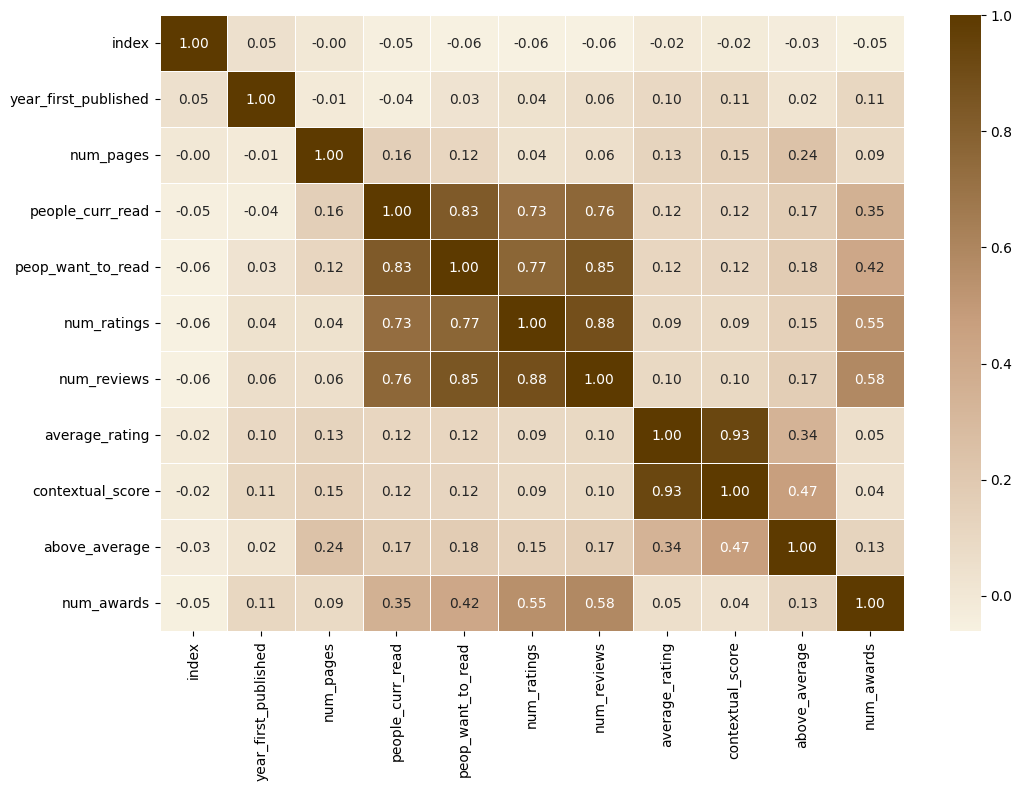

In [122]:

from matplotlib.colors import LinearSegmentedColormap
# Paleta inspirada en tonos sepia y marrón de la presentación pptx
sepia_cmap = LinearSegmentedColormap.from_list(
    "sepia",
    ["#f7f1e1", "#c89f7e", "#5D3A00"]  # beige claro → marrón medio → marrón oscuro
)
corr_matrix = df.drop(['book_id', 'contextual_mean', 'contextual_sd'], axis=1).corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap=sepia_cmap, fmt=".2f", linewidths=0.5)

Existen varios pares de variables con correlaciones notorias:
- Cantidad de valoraciones y cantidad de reseñas: en este caso, se decide mantener solamente la primera variable, dado que los datos tienen más información sobre las valoraciones que sobre las reseñas
- Cantidad de valoraciones/reseñas y número de lectores: el resultado es esperable debido a que al tener un libro un mayor alcance hay más usuarios que dan su opinión
- Cantidad de valoraciones/reseñas y número de lectores potenciales: este resultado también es esperable pues los usuarios pueden interesarse en libros según cuánto alcance y acogia hayan tenido en la comunidad.
- Cantidad de lectores y lectores potenciales: puede derivarse de las dos relaciones anteriores, puesto que los libros con mayor alcance son también los que más valoraciones reciben, y estas influyen en los intereses de los futuros lectores

Debido a la interacción múltiple de los últimos tres puntos, se combinan la cantidad de lectores activos y potenciales en una nueva variable que indica el total de usuarios interesados en el libro

In [123]:
df['interested_users'] = df['peop_want_to_read'] + df['people_curr_read']

<Axes: >

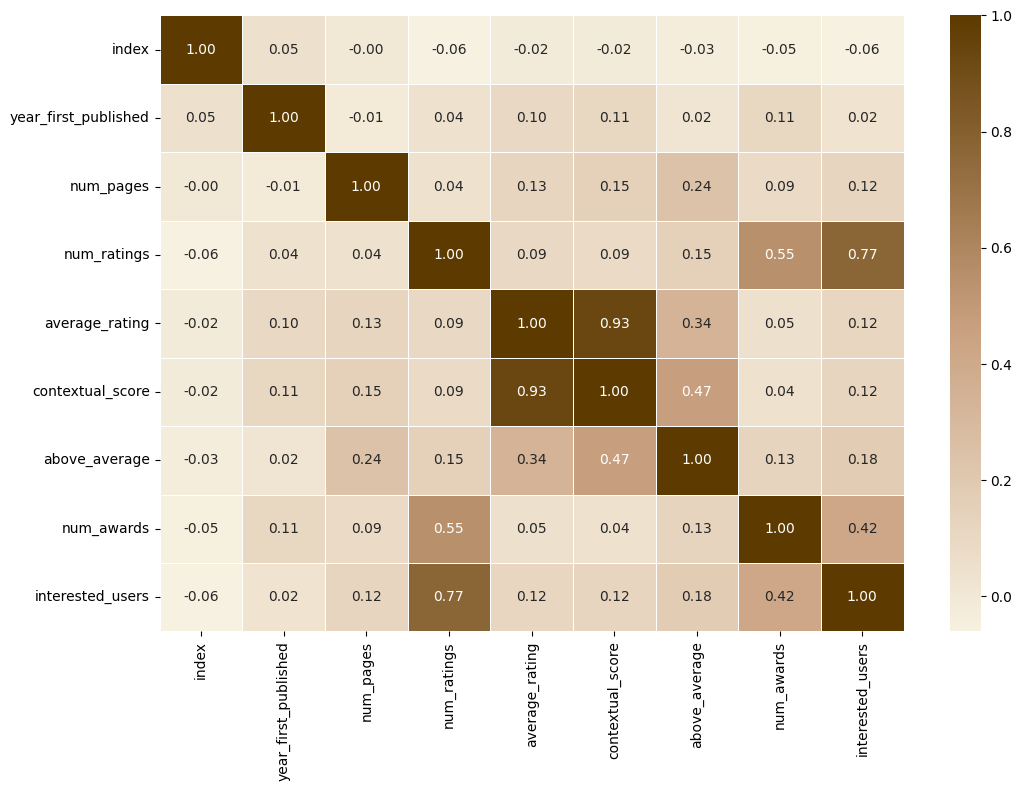

In [124]:
corr_matrix = df.drop(['book_id', 'contextual_mean', 'contextual_sd', 'num_reviews', 'peop_want_to_read', 'people_curr_read'], axis=1).corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap=sepia_cmap, fmt=".2f", linewidths=0.5)

Este será el conjunto de variables numéricas empleadas en los modelos. La métrica que las relacionará será la siguiente:

In [125]:
from scipy.spatial.distance import jaccard

to_log = ['interested_users', 'num_ratings', 'num_awards', 'year_first_published', 'num_pages']
to_standarize = ['above_average']
keep = ['contextual_score']
features = keep + to_log + to_standarize

def custom_distance(x1, x2, weights={}):
    dist_num = np.sqrt(sum(weights.get(f, 1) * (x1[i] - x2[i]) ** 2 for i, f in enumerate(features)))
    dist_bin = jaccard(x1[-2], x2[-2])

    return dist_num + dist_bin

Emplea una combinación de una distancia euclideana ponderada para las variables numéricas con la distancia de Jaccard sobre los vectores de géneros. La finalidad de la ponderación en el primer caso es ajustar la influencia de algunas de las variables numéricas según las necesidades del modelo concreto.

## Análisis de factores de éxito

Para el análisis de los factores de éxito de los libros se emplea un enfoque basado en agrupamiento e inspección de los clústers. Las variables utilizadas son las que se decidió mantener al analizar las correlaciones.

Antes del agrupamiento son realizadas transformaciones para estandarizar los datos, de forma que los desbalanceos detectados en las variables sean suavizados. Son las siguientes:

- Transformación logarítmica: las variables con desbalanceo más extremo primeramente son transformadas a logaritmo, con una pequeña constante (1), para el caso de valores 0
- Escalador robusto: todas las variables son estandarizadas mediante el escalador robusto, basado en la mediana y el rango intercuartil

In [126]:
import math
from sklearn.preprocessing import RobustScaler

def prepare_features(in_df):
  ready = in_df[keep].copy()
  ready[to_log] = pd.DataFrame(RobustScaler().fit_transform(in_df[to_log].map(lambda x: math.log1p(x))))
  ready[to_standarize] = pd.DataFrame(RobustScaler().fit_transform(in_df[to_standarize]))
  ready.fillna(ready.mean(), inplace=True)
  ready['genres_vector'] = in_df['genres_vector']
  ready['book_id_title'] = in_df['book_id_title']
  return ready

input = prepare_features(df)

El algoritmo empleado es el agrupamiento aglomerativo, se aplica sobre una matriz de distancias precalculada, resultante de computar la métrica personalizada sobre las instancias. El número de clústers es establecido en 3, buscando distinguir principalmente por rangos de valoraciones/alcance

In [127]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering

matrix = squareform(pdist(input, metric=custom_distance))
clustering = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='precomputed')

labels = clustering.fit_predict(matrix)
df['cluster'] = labels

Sin embargo, al comprobar la distribución de los clústers se observa que el resultado fue un clúster mayoritario con otros dos con un número reducido de instancias

([<matplotlib.patches.Wedge at 0x790e04d86cd0>,
 [Text(-1.0648536054678515, 0.2758383565099634, '751'),
  Text(0.43716370364225304, -1.0093997702683455, '522'),
  Text(0.8675238917709139, 0.676315235083942, '518')],
 [Text(-0.5808292393461006, 0.15045728536907094, '41.9%'),
  Text(0.2384529292594107, -0.5505816928736429, '29.1%'),
  Text(0.47319485005686207, 0.3688992191366956, '28.9%')])

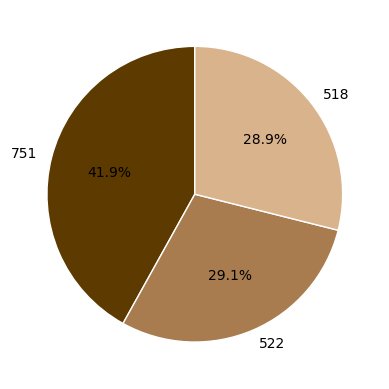

In [141]:
counts = df['cluster'].value_counts()
plt.pie(x=counts, labels=counts, colors=custom_palette[:len(counts)],  # Usar solo los colores necesarios
    autopct='%1.1f%%',  # Mostrar porcentajes
    startangle=90,  # Rotación inicial
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},  # Borde blanco para mejor contorno
    textprops={'fontsize': 10})


Por el funcionamiento del agrupamiento aglomerativo puede deberse a la distribución de las distancias en la matrix. Si existen valores extremos o atípicos que desbalanceen la distribución, el rango de las distancias es mucho mayor a su dispersión real, por lo que instancias en teoría diferentes serían asignadas al mismo clúster. Esto es una explicación de la existencia de un grupo mayoritario. La visualización de los valores de distancias en la matriz confirma el caso:

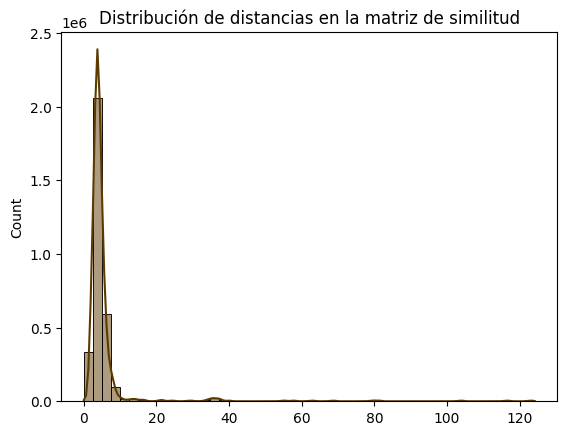

In [129]:
sns.histplot(matrix.flatten(), bins=50, kde=True, color=custom_palette[0] )
plt.title("Distribución de distancias en la matriz de similitud")
plt.show()

La existencia de unos pocos valores de distancia muy alejados de la mayoría indica que siguen existiendo rangos extremos en las variables, a pesar de la estandarización aplicada. Estos pueden corresponderse a algunos de los valores estadísticamente anómalos, pero correctos en la lógica de negocio. Para mitigar su efecto se aplica winsorizing, llevado los valores extremos a los del quantil 0.05 y 0.95 en cada caso

In [130]:
input = prepare_features(df)
to_crop = input.columns[:-2]
quantile_9 = input[to_crop].quantile(q=0.95)
quantile_1 = input[to_crop].quantile(q=0.05)

for col in input[to_crop]:
  input[col] = np.where(input[col] > quantile_9[col], quantile_9[col], np.where(input[col] < quantile_1[col], quantile_1[col], input[col]))

matrix = squareform(pdist(input, metric=custom_distance))

labels = clustering.fit_predict(matrix)
df['cluster'] = labels

En este caso los clusters se encuentran más balanceados

([<matplotlib.patches.Wedge at 0x790e04d23110>,
 [Text(-1.0648536054678515, 0.2758383565099634, '751'),
  Text(0.43716370364225304, -1.0093997702683455, '522'),
  Text(0.8675238917709139, 0.676315235083942, '518')],
 [Text(-0.5808292393461006, 0.15045728536907094, '41.9%'),
  Text(0.2384529292594107, -0.5505816928736429, '29.1%'),
  Text(0.47319485005686207, 0.3688992191366956, '28.9%')])

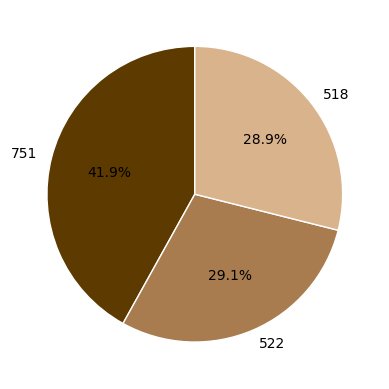

In [131]:
counts = df['cluster'].value_counts()
plt.pie(x=counts, labels=counts, colors=custom_palette[:len(counts)],  # Usar solo los colores necesarios
    autopct='%1.1f%%',  # Mostrar porcentajes
    startangle=90,  # Rotación inicial
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},  # Borde blanco para mejor contorno
    textprops={'fontsize': 10})

## Sistema recomendador

Para la recomendación de libros se reutiliza la métrica de distancia definida con anterioridad. Al emplear las descriptivas numéricas de los datos y los géneros estandarizados se logra que las similitudes estén basadas en los parámetros que caracterizan a los libros (como la época, extensión o alcance), al contrario de comparaciones literales de texto, en que las similitudes pueden no tener significado.

La obtención de los resultados más similares no está restringida a una cantidad de N-primeros. Se realizan recomendaciones basadas en los siguientes criterios:

- Libros similares: aquellas obras no relacionadas con el libro de entrada que más se le asemejan
- Más del autor: resto de obras del autor más parecidas al libro de entrada
- Recopilatorios: sugiere recopilatorios de obras del autor del libro, si este cuenta con alguna

In [132]:
out_cols = check_cols + ['year_first_published', 'main_genres']

def recommend_books(id, source, to_compute, n=5):
  current = source[source['book_id_title'] == id].iloc[0, :]
  current_features = to_compute[to_compute['book_id_title'] == id].iloc[0, :]

  source['distance'] = to_compute.apply(lambda r: custom_distance(current_features.values, r.values, weights={'year_first_published': 0.6, 'num_pages': 0.5}), axis=1)
  results = source.sort_values(by='distance', ascending=True)

  top_similar = results[(results['author'] != current['author'])].iloc[0:n, :]

  of_series = pd.DataFrame({}, columns=['book_id_title'] + out_cols)

  same_author = results[(results['author'] == current['author'])]
  same_author = same_author.iloc[1:(min(n, same_author.shape[0])+1), :]
  collections = compilations[compilations['author'] == current['author']]

  return top_similar, same_author, collections

Se provee un ejemplo de entrada con un libro para el que se cuenta con recopilatorios para el autor (Arthur Connan Doyle)

In [133]:
target = '194366.The_Return_of_Sherlock_Holmes'
similars, same_author, collections = recommend_books(target, df, input)

Información completa del libro origen:

In [134]:
print('Libro origen:')
df[df['book_id_title'] == target][out_cols]

Libro origen:


,book_title,book_series,author,num_pages,year_first_published,main_genres
474,The Return of Sherlock Holmes,['Sherlock Holmes'],Arthur Conan Doyle,455.0,1905.0,"[Thriller, Short Stories]"


Libros no relacionados similares:

In [135]:
print('Libros similares:')
similars[out_cols]

Libros similares:


,book_title,book_series,author,num_pages,year_first_published,main_genres
1537,The Exploits of Sherlock Holmes,"['Los archivos de Baker Street', 'Sherlock Hol...",Adrian Conan Doyle,338.0,1954.0,"[Thriller, Short Stories]"
1541,The Further Adventures of Sherlock Holmes: Aft...,NaN,Richard Lancelyn Green,272.0,1985.0,"[Thriller, Short Stories]"
1334,Selected Stories of Anton Chekhov,NaN,Anton Chekhov,496.0,1903.0,"[Short Stories, Regional & National, Literary ..."
831,The Fall of the House of Usher and Other Tales,NaN,Edgar Allan Poe,400.0,1960.0,"[Short Stories, Literary & Classics, Horror, T..."
193,Death on the Nile,"['Hercule Poirot', 'Colonel Race']",Agatha Christie,352.0,1937.0,[Thriller]


Más libros del autor:

In [136]:
if not same_author.empty:
  print('Más del autor:')

same_author[out_cols]

Más del autor:


,book_title,book_series,author,num_pages,year_first_published,main_genres
475,The Memoirs of Sherlock Holmes,['Sherlock Holmes'],Arthur Conan Doyle,378.0,1893.0,"[Thriller, Short Stories]"
1532,His Last Bow,['Sherlock Holmes'],Arthur Conan Doyle,242.0,1917.0,"[Thriller, Short Stories]"
315,The Case-Book of Sherlock Holmes,['Sherlock Holmes'],Arthur Conan Doyle,303.0,1927.0,"[Thriller, Short Stories]"
936,The Adventures of Sherlock Holmes,"['Sherlock Holmes', 'The Adventures of Sherloc...",Arthur Conan Doyle,389.0,1892.0,"[Thriller, Short Stories]"
14,A Study in Scarlet,"['Sherlock Holmes', 'Sherlock Holmes (PTS 2008...",Arthur Conan Doyle,123.0,1887.0,"[Thriller, Historical]"


Recopilatorios del autor (de existir):

In [137]:
if not collections.empty:
  print('Recopilatorios disponibles del autor:')

collections[out_cols]

Recopilatorios disponibles del autor:


,book_title,book_series,author,num_pages,year_first_published,main_genres
454,The Complete Sherlock Holmes,['Sherlock Holmes'],Arthur Conan Doyle,1796.0,1915.0,"[Thriller, Short Stories]"
947,Sherlock Holmes: The Complete Novels and Stori...,['Sherlock Holmes'],Arthur Conan Doyle,1059.0,1927.0,"[Thriller, Short Stories]"
